训练集大小: (10132, 52), 测试集大小: (21120, 52)
原始训练集大小: (10132, 52), 增强后训练集大小: (10560, 52)
使用设备: cuda
Epoch [1/40], Train Loss: 2.1024, Train Accuracy: 32.21%
Epoch [1/40], Val Loss: 1.7346, Val Accuracy: 41.86%
Epoch [2/40], Train Loss: 1.6549, Train Accuracy: 46.48%
Epoch [2/40], Val Loss: 1.4693, Val Accuracy: 53.74%
Epoch [3/40], Train Loss: 1.4565, Train Accuracy: 53.28%
Epoch [3/40], Val Loss: 1.3454, Val Accuracy: 56.53%
Epoch [4/40], Train Loss: 1.2984, Train Accuracy: 58.34%
Epoch [4/40], Val Loss: 1.1352, Val Accuracy: 62.26%
Epoch [5/40], Train Loss: 1.1547, Train Accuracy: 62.64%
Epoch [5/40], Val Loss: 1.0469, Val Accuracy: 65.67%
Epoch [6/40], Train Loss: 1.1086, Train Accuracy: 65.43%
Epoch [6/40], Val Loss: 0.9320, Val Accuracy: 68.84%
Epoch [7/40], Train Loss: 0.9706, Train Accuracy: 67.97%
Epoch [7/40], Val Loss: 0.8831, Val Accuracy: 69.93%
Epoch [8/40], Train Loss: 0.9088, Train Accuracy: 69.59%
Epoch [8/40], Val Loss: 0.8456, Val Accuracy: 71.40%
Epoch [9/40], Train Loss: 

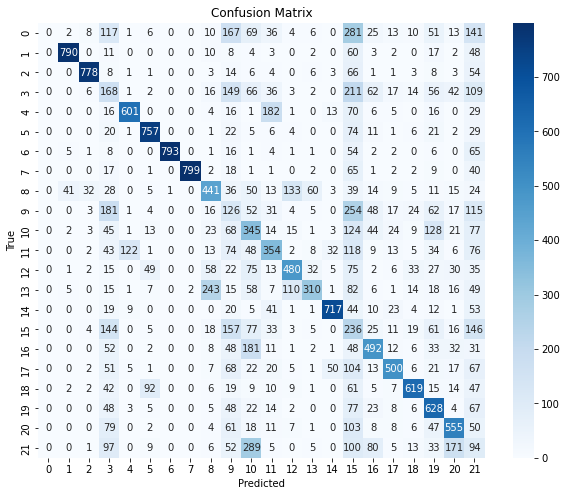

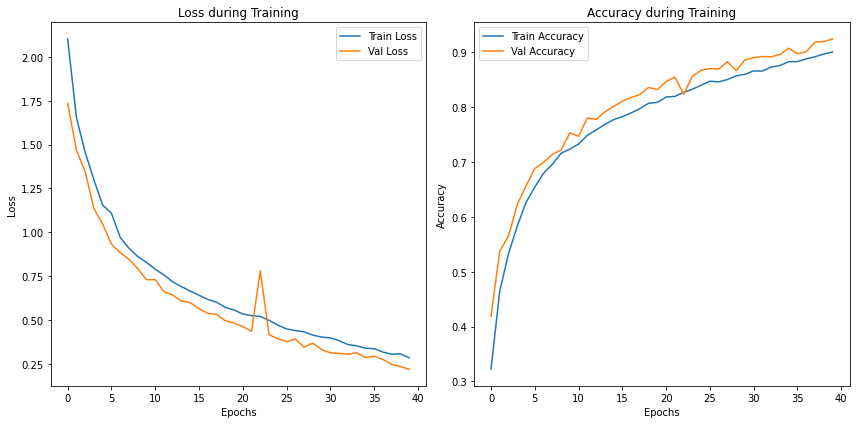

In [8]:
# 导入必要的库
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# 加载数据函数，加载指定文件夹内的数据文件，并按顺序合并
def load_te_data(folder_path):
    data = []  # 存储数据
    labels = []  # 存储标签
    files = sorted(os.listdir(folder_path))  # 保证文件顺序一致
    for file in files:
        if file.endswith('.dat'):  # 只处理以 '.dat' 结尾的文件
            file_path = os.path.join(folder_path, file)
            # 读取文件，假设是空格分隔的数据
            df = pd.read_csv(file_path, sep='\\s+', header=None)
            # 提取标签（假设标签位于文件名中）
            label = int(file[1:3])  # 从文件名中提取标签，例如 'd00.dat' 提取 '00'
            data.append(df)  # 添加数据
            labels.append(np.full((df.shape[0],), label))  # 添加对应的标签
    # 合并所有数据和标签
    return pd.concat(data, axis=0), np.concatenate(labels, axis=0)

# 加载训练集和测试集数据
train_data, train_labels = load_te_data('TE_train')
test_data, test_labels = load_te_data('TE_test')

# 将标签添加到数据中，方便后续操作
train_data['Label'] = train_labels
test_data['Label'] = test_labels

# 确保训练集和测试集特征对齐，去除标签列进行对比
common_columns = train_data.columns.intersection(test_data.columns).drop('Label')
train_data = train_data[common_columns.to_list() + ['Label']]
test_data = test_data[common_columns.to_list() + ['Label']]

# 数据标准化：为了后续模型训练，确保特征具有相同的尺度
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data.drop('Label', axis=1))  # 训练集特征标准化
X_test = scaler.transform(test_data.drop('Label', axis=1))  # 测试集特征标准化
y_train = train_data['Label'].values  # 训练集标签
y_test = test_data['Label'].values  # 测试集标签

# 输出训练集和测试集的大小
print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

# 如果训练集类别不平衡，使用 SMOTE 技术进行过采样
smote = SMOTE(random_state=42)  # 初始化 SMOTE 对象
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # 对训练集进行过采样

# 输出过采样前后的训练集大小
print(f"原始训练集大小: {X_train.shape}, 增强后训练集大小: {X_train_resampled.shape}")

# 1. 特征选择：使用 SelectKBest
# 选择前 50 个最相关的特征
selector = SelectKBest(f_classif, k=50)
X_train_resampled = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test = selector.transform(X_test)

# 2. 降维：使用 PCA
pca = PCA(n_components=30)  # 降维到 30 维
X_train_resampled = pca.fit_transform(X_train_resampled)
X_test = pca.transform(X_test)

# 将数据转换为 PyTorch 张量
X_train_resampled = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 定义 CNN 模型
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)  # 调整卷积层
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # 增加通道数
        self.pool = nn.MaxPool1d(2)
        
        # 计算卷积和池化后特征的大小
        # 假设输入的特征数量为 input_size
        conv1_output_size = input_size  # 初始特征长度
        conv1_output_size = (conv1_output_size + 2 * 1 - 3) // 1 + 1  # 计算卷积层的输出大小，padding=1, kernel_size=3, stride=1
        conv1_output_size = conv1_output_size // 2  # 池化层后大小，stride=2, kernel_size=2

        conv2_output_size = conv1_output_size  # 第二层卷积后的大小与第一层相同
        conv2_output_size = (conv2_output_size + 2 * 1 - 3) // 1 + 1  # 第二层卷积
        conv2_output_size = conv2_output_size // 2  # 池化

        # 计算全连接层输入的特征数量
        # 128 为第二层卷积的输出通道数
        self.fc1 = nn.Linear(128 * conv2_output_size, 256)  # 增加全连接层神经元数
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 其余代码保持不变

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 初始化模型
num_classes = 22  # 假设您有22个类别
model = CNNModel(input_size=X_train_resampled.shape[1], num_classes=num_classes).to(device)

# 数据调整以适应模型输入格式 (CNN 需要 3D 输入)
X_train_resampled = X_train_resampled.unsqueeze(1).to(device)  # 增加一个维度 (batch_size, 1, features)
X_test = X_test.unsqueeze(1).to(device)  # 测试集数据

# 数据加载器
train_dataset = TensorDataset(X_train_resampled, y_train_resampled)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 通过划分验证集
val_size = int(0.2 * len(train_loader.dataset))  # 20% 的数据作为验证集
train_size = len(train_loader.dataset) - val_size
train_dataset, val_dataset = random_split(train_loader.dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
epochs = 40
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 计算训练准确率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # 在验证集上评估
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {100 * correct / total:.2f}%")
    print(f"Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {100 * val_correct / val_total:.2f}%")

# 评估模型在测试集上的准确率
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    
    # 测试集准确率
    accuracy = accuracy_score(y_test.cpu(), predicted.cpu())
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # 计算并输出 MAE, MSE, RMSE
    mae = mean_absolute_error(y_test.cpu(), predicted.cpu())
    mse = mean_squared_error(y_test.cpu(), predicted.cpu())
    rmse = np.sqrt(mse)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # 混淆矩阵
    cm = confusion_matrix(y_test.cpu(), predicted.cpu())

    # 绘制混淆矩阵热图
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 可视化训练和验证过程
plt.figure(figsize=(12, 6))

# 绘制训练和验证过程中的损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和验证过程中的准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
引入了残差网络，缓解了深层网络中的梯度消失问题，提升了训练的稳定性。
优化器选择和学习率调度的改进有助于提高模型收敛的速度和精度。
更深的网络结构和 更大的全连接层 增强了模型的表达能力。
使用了 SMOTE 和 Dropout，有效减少了过拟合，解决了类别不平衡问题。

使用设备: cuda
Epoch [1/50], Train Loss: 2.4228, Train Accuracy: 27.69%, Test Accuracy: 37.63%
Epoch [2/50], Train Loss: 1.9565, Train Accuracy: 40.72%, Test Accuracy: 41.61%
Epoch [3/50], Train Loss: 1.7600, Train Accuracy: 46.70%, Test Accuracy: 44.07%
Epoch [4/50], Train Loss: 1.6317, Train Accuracy: 50.90%, Test Accuracy: 46.08%
Epoch [5/50], Train Loss: 1.5372, Train Accuracy: 53.25%, Test Accuracy: 47.13%
Epoch [6/50], Train Loss: 1.4664, Train Accuracy: 55.39%, Test Accuracy: 47.87%
Epoch [7/50], Train Loss: 1.4000, Train Accuracy: 57.09%, Test Accuracy: 48.31%
Epoch [8/50], Train Loss: 1.3502, Train Accuracy: 58.91%, Test Accuracy: 50.07%
Epoch [9/50], Train Loss: 1.2858, Train Accuracy: 60.95%, Test Accuracy: 51.50%
Epoch [10/50], Train Loss: 1.2261, Train Accuracy: 63.25%, Test Accuracy: 51.98%
Epoch [11/50], Train Loss: 1.1627, Train Accuracy: 65.07%, Test Accuracy: 53.98%
Epoch [12/50], Train Loss: 1.1124, Train Accuracy: 66.61%, Test Accuracy: 54.37%
Epoch [13/50], Train Loss:

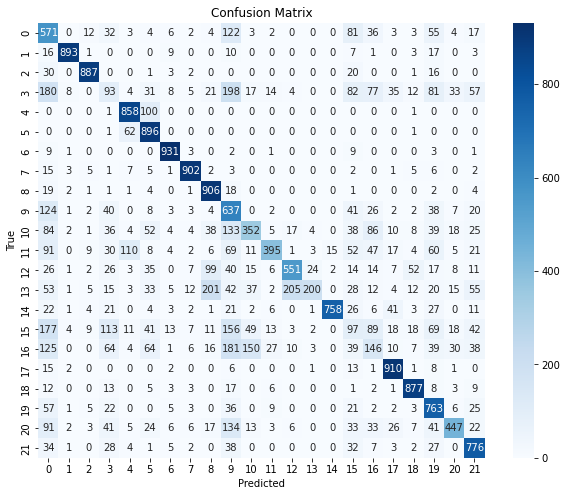

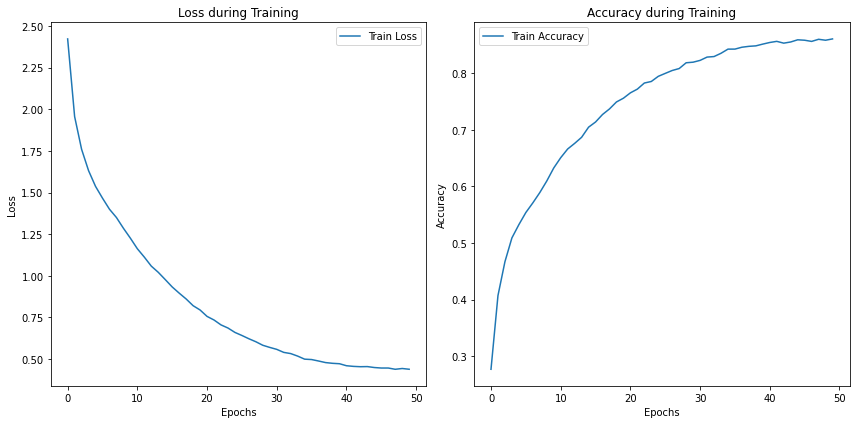

In [7]:
# 导入必要的库
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from torch.optim.lr_scheduler import CosineAnnealingLR

# 加载数据函数，加载指定文件夹内的数据文件，并按顺序合并
def load_te_data(folder_path):
    data = []  # 存储数据
    labels = []  # 存储标签
    files = sorted(os.listdir(folder_path))  # 保证文件顺序一致
    for file in files:
        if file.endswith('.dat'):  # 只处理以 '.dat' 结尾的文件
            file_path = os.path.join(folder_path, file)
            # 读取文件，假设是空格分隔的数据
            df = pd.read_csv(file_path, sep='\\s+', header=None)
            # 提取标签（假设标签位于文件名中）
            label = int(file[1:3])  # 从文件名中提取标签，例如 'd00.dat' 提取 '00'
            data.append(df)  # 添加数据
            labels.append(np.full((df.shape[0],), label))  # 添加对应的标签
    # 合并所有数据和标签
    return pd.concat(data, axis=0), np.concatenate(labels, axis=0)

# 加载训练集和测试集数据
train_data, train_labels = load_te_data('TE_train_new')
test_data, test_labels = load_te_data('TE_test')

# 将标签添加到数据中，方便后续操作
train_data['Label'] = train_labels
test_data['Label'] = test_labels

# 确保训练集和测试集特征对齐，去除标签列进行对比
common_columns = train_data.columns.intersection(test_data.columns).drop('Label')
train_data = train_data[common_columns.to_list() + ['Label']]
test_data = test_data[common_columns.to_list() + ['Label']]

# 数据标准化：为了后续模型训练，确保特征具有相同的尺度
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data.drop('Label', axis=1))  # 训练集特征标准化
X_test = scaler.transform(test_data.drop('Label', axis=1))  # 测试集特征标准化
y_train = train_data['Label'].values  # 训练集标签
y_test = test_data['Label'].values  # 测试集标签

# 如果训练集类别不平衡，使用 SMOTE 技术进行过采样
smote = SMOTE(random_state=42)  # 初始化 SMOTE 对象
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # 对训练集进行过采样

# 1. 特征选择：使用 SelectKBest
# 选择前 100 个最相关的特征
selector = SelectKBest(f_classif, k='all')
X_train_resampled = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test = selector.transform(X_test)

# 2. 降维：不再使用 PCA，改为直接使用选择后的特征
# X_train_resampled = pca.fit_transform(X_train_resampled)
# X_test = pca.transform(X_test)

# 将数据转换为 PyTorch 张量
X_train_resampled = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 定义残差块（ResidualBlock）
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        # 1D 卷积层：输入通道 in_channels，输出通道 out_channels，卷积核大小 3，步幅 1，填充 1
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        # 批归一化层：对输出进行归一化处理
        self.bn = nn.BatchNorm1d(out_channels)
        # ReLU 激活函数
        self.relu = nn.ReLU()
        # 如果输入通道数和输出通道数相同，跳跃连接是恒等映射，否则使用 1x1 卷积调整维度
        self.shortcut = nn.Identity() if in_channels == out_channels else nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # 卷积层 + 批归一化 + 激活函数
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        # 跳跃连接
        shortcut = self.shortcut(x)
        return out + shortcut  # 残差连接

# 改进后的 CNN 模型
class ImprovedCNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedCNNModel, self).__init__()
        # 三个残差块
        self.resblock1 = ResidualBlock(1, 64)
        self.resblock2 = ResidualBlock(64, 128)
        self.resblock3 = ResidualBlock(128, 128)  # 添加了一个残差块
        # 最大池化层，用于减少特征图的尺寸
        self.pool = nn.MaxPool1d(2)
        # Dropout 层，用于防止过拟合，概率为 0.4
        self.dropout = nn.Dropout(0.4)
        # 全连接层1：输入维度为 128 * (input_size // 8)，输出维度为 256
        self.fc1 = nn.Linear(128 * (input_size // 8), 256)
        # 全连接层2：输入维度为 256，输出维度为 128
        self.fc2 = nn.Linear(256, 128)
        # 全连接层3：输出类别数
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # 通过 3 个残差块，池化层，提取特征
        x = self.pool(self.resblock1(x))
        x = self.pool(self.resblock2(x))
        x = self.pool(self.resblock3(x))
        # 展平操作，将多维的输入一维化，准备输入到全连接层
        x = x.view(x.size(0), -1)
        # 全连接层1 + ReLU 激活函数
        x = torch.relu(self.fc1(x))
        # Dropout 防止过拟合
        x = self.dropout(x)
        # 全连接层2 + ReLU 激活函数
        x = torch.relu(self.fc2(x))
        # Dropout 防止过拟合
        x = self.dropout(x)
        # 最后一层全连接层输出预测
        x = self.fc3(x)
        return x

# 设置设备，选择 GPU 或 CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 初始化模型，假设类别数为22
num_classes = 22
# 输入数据的特征数量为 X_train_resampled 的列数，传入模型中
model = ImprovedCNNModel(input_size=X_train_resampled.shape[1], num_classes=num_classes).to(device)

# 将输入数据调整为 (batch_size, 1, features) 的形状
X_train_resampled = X_train_resampled.unsqueeze(1).to(device)
X_test = X_test.unsqueeze(1).to(device)

# 创建数据加载器，用于将训练数据分批次加载
train_dataset = TensorDataset(X_train_resampled, y_train_resampled)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 增加 batch_size

# 划分验证集
val_size = int(0.2 * len(train_loader.dataset))  # 20%的数据作为验证集
train_size = len(train_loader.dataset) - val_size  # 剩余80%作为训练集
# 使用随机划分训练集和验证集
train_dataset, val_dataset = random_split(train_loader.dataset, [train_size, val_size])

# 为验证集创建数据加载器
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 定义优化器和损失函数
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # 使用 AdamW 优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数（适用于多分类任务）

# 学习率调度器，使用余弦退火调度器
scheduler = CosineAnnealingLR(optimizer, T_max=50)  # 延长学习率调度周期

# 改进后的训练循环
epochs = 50
train_losses = []  # 存储每轮训练的损失
train_accuracies = []  # 存储每轮训练的准确率

# 循环训练
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0  # 当前epoch的累积损失
    correct = 0  # 当前epoch正确分类的样本数
    total = 0  # 当前epoch的样本总数
    
    # 遍历训练数据加载器（train_loader）中的每个批次
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移动到GPU/CPU

        optimizer.zero_grad()  # 清除之前的梯度
        outputs = model(inputs)  # 前向传播，得到模型的输出
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新模型参数

        running_loss += loss.item()  # 累加当前批次的损失

        # 计算训练准确率
        _, predicted = torch.max(outputs, 1)  # 获取预测类别
        total += labels.size(0)  # 累计样本数
        correct += (predicted == labels).sum().item()  # 累计正确预测的样本数

    # 记录当前epoch的训练损失和准确率
    train_losses.append(running_loss / len(train_loader))  # 每个epoch的平均损失
    train_accuracies.append(correct / total)  # 每个epoch的训练准确率

    # 在验证集上评估模型
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0  # 当前epoch的验证损失
    val_correct = 0  # 当前epoch验证集正确分类的样本数
    val_total = 0  # 当前epoch验证集的样本总数
    
    # 禁用梯度计算，提高内存效率
    with torch.no_grad():
        # 遍历验证数据加载器（val_loader）
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将数据移到GPU/CPU

            outputs = model(inputs)  # 前向传播，得到模型输出
            loss = criterion(outputs, labels)  # 计算损失
            val_loss += loss.item()  # 累加损失

            # 计算验证准确率
            _, predicted = torch.max(outputs, 1)  # 获取预测类别
            val_total += labels.size(0)  # 累计验证集样本数
            val_correct += (predicted == labels).sum().item()  # 累计正确预测的样本数

    # 记录验证损失和准确率
    val_losses.append(val_loss / len(val_loader))  # 每个epoch的验证集损失
    val_accuracies.append(val_correct / val_total)  # 每个epoch的验证准确率

    # 打印当前epoch的训练和验证结果
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {100 * correct / total:.2f}%")
    print(f"Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {100 * val_correct / val_total:.2f}%")

# 在测试集上评估模型
model.eval()  # 设置模型为评估模式
with torch.no_grad():  # 禁用梯度计算
    outputs = model(X_test)  # 对测试集进行预测
    _, predicted = torch.max(outputs, 1)  # 获取预测结果

    # 计算测试集准确率
    accuracy = accuracy_score(y_test.cpu(), predicted.cpu())  # 计算准确率
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # 计算回归模型的误差指标：MAE, MSE, RMSE
    mae = mean_absolute_error(y_test.cpu(), predicted.cpu())  # 平均绝对误差
    mse = mean_squared_error(y_test.cpu(), predicted.cpu())  # 均方误差
    rmse = np.sqrt(mse)  # 均方根误差

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # 计算并输出混淆矩阵
    cm = confusion_matrix(y_test.cpu(), predicted.cpu())  # 混淆矩阵

    # 绘制混淆矩阵热图
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 可视化训练过程中的损失和准确率
plt.figure(figsize=(12, 6))

# 绘制训练过程中的损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练过程中的准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
